In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import sys
pd.set_option('display.max_columns', None)



In [2]:
src_path = os.path.abspath(os.path.join(os.getcwd(), "../../../src"))
sys.path.append(src_path)
from pipeline import ModelPipeline


In [3]:
xgb_pipeline = ModelPipeline(dataset_path='/Users/abhitay/Developer/Columbia_projects/CAP/dsi-capstone-spring-2025-TD-anti-money-laundering/Code/Abhitay/IBM/Subset Transactions.csv')

xgb_pipeline.run_preprocessing()

xgb_pipeline.df

Running preprocessing pipeline...

Creating unique ids...

Normalizing currency...

Extracting time features...

Adding cyclical encoding to time feats...

Applying label encoding...

Label encoding applied to columns: ['payment_type', 'day_of_week', 'from_bank', 'to_bank', 'sent_currency', 
'received_currency']

Extracting graph features...

Using default weight columns: ['sent_amount', 'received_amount']

Graph features computed using: ['sent_amount', 'received_amount']

**Note**, previously graph-based features were calculated using only `sent_amount` as edge weight (only based on 
outgoing transactions). Now both sent and received amounts are included by default.

New feature columns added: degree_centrality_sent_amount, degree_centrality_received_amount, 
pagerank_sent_amount, pagerank_received_amount

Preprocessing completed successfully!

{
    'renamed': True,
    'duplicates_removed': True,
    'unique_ids_created': True,
    'currency_normalized': True,
    'time_features_extracted': True,
    'cyclical_encoded': True,
    'weekend_encoded': True,
    'label_encoded': True,
    'neighbor_context_computed': True,
    'normalized': False
}

,from_bank,to_bank,received_amount,received_currency,sent_amount,sent_currency,payment_type,is_laundering,from_account_id,to_account_id,from_account_idx,to_account_idx,sent_amount_usd,received_amount_usd,hour_of_day,day_of_week,seconds_since_midnight,timestamp_int,timestamp_scaled,day_sin,day_cos,time_of_day_sin,time_of_day_cos,is_weekend,degree_centrality_sent_amount,pagerank_sent_amount,degree_centrality_received_amount,pagerank_received_amount
0,8,8,3697.340000,12,3697.340000,12,5,0,10_8000EBD30,10_8000EBD30,0,0,3.697340e+03,3.697340e+03,0,3,1200,1.661992e+09,1.661992e+09,0.433884,-0.900969,0.087156,0.996195,0,0.000139,0.000050,0.000139,0.000050
1,109,0,0.010000,12,0.010000,12,3,0,3208_8000F4580,1_8000F5340,1,81239,1.000000e-02,1.000000e-02,0,3,1200,1.661992e+09,1.661992e+09,0.433884,-0.900969,0.087156,0.996195,0,0.000019,0.000001,0.000019,0.000001
2,10,10,2806.970000,12,2806.970000,12,5,0,12_8000F5030,12_8000F5030,2,2,2.806970e+03,2.806970e+03,0,3,120,1.661991e+09,1.661991e+09,0.433884,-0.900969,0.008727,0.999962,0,0.000195,0.000243,0.000195,0.000243
3,8,8,36682.970000,12,36682.970000,12,5,0,10_8000F5200,10_8000F5200,3,3,3.668297e+04,3.668297e+04,0,3,360,1.661991e+09,1.661991e+09,0.433884,-0.900969,0.026177,0.999657,0,0.000121,0.000008,0.000121,0.000008
4,0,0,6162.440000,12,6162.440000,12,5,0,1_8000F5AD0,1_8000F5AD0,4,4,6.162440e+03,6.162440e+03,0,3,180,1.661991e+09,1.661991e+09,0.433884,-0.900969,0.013090,0.999914,0,0.000177,0.000092,0.000177,0.000092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250896,4222,3797,0.000223,1,0.000223,1,1,0,152627_813D6AFF1,53744_814237D21,48362,48634,1.876695e-08,1.876695e-08,23,5,85260,1.662853e+09,1.662853e+09,-0.974928,-0.222521,-0.082808,0.996566,1,0.000046,0.000007,0.000046,0.000007
1250897,4672,4671,0.417737,1,0.417737,1,1,0,254565_8147A3EC1,254355_8147A3E21,48834,75038,3.515537e-05,3.515537e-05,23,5,84720,1.662853e+09,1.662853e+09,-0.974928,-0.222521,-0.121869,0.992546,1,0.000037,0.000003,0.000037,0.000003
1250898,12,4222,0.051436,1,0.051436,1,1,0,15_813D8E211,152627_8147AA0B1,48375,69359,4.328685e-06,4.328685e-06,23,5,85860,1.662854e+09,1.662854e+09,-0.974928,-0.222521,-0.039260,0.999229,1,0.000046,0.000030,0.000046,0.000030
1250899,12,4222,0.084692,1,0.084692,1,1,0,15_813D8E211,152627_8147AA0B1,48375,69359,7.127401e-06,7.127401e-06,23,5,85200,1.662853e+09,1.662853e+09,-0.974928,-0.222521,-0.087156,0.996195,1,0.000046,0.000030,0.000046,0.000030


In [4]:
df = xgb_pipeline.df.copy()
df["TxID"] = df.index

# Step 1: Prepare copies for joins
# Forward: receiver becomes sender
forward_df = df[['TxID', 'from_account_id', 'sent_amount_usd']].rename(
    columns={'TxID': 'forward_TxID',
             'from_account_id': 'receiver',
             'sent_amount_usd': 'forward_amount'}
)

# Backward: sender was receiver
backward_df = df[['TxID', 'to_account_id', 'sent_amount_usd']].rename(
    columns={'TxID': 'backward_TxID',
             'to_account_id': 'sender',
             'sent_amount_usd': 'backward_amount'}
)

# Step 2: Merge to get one-hop forward transactions (based on receiver)
df_forward = df.merge(forward_df, how='left', left_on='to_account_id', right_on='receiver')
# Remove self-join: keep rows with no match or where TxIDs differ
df_forward = df_forward[
    (df_forward['forward_TxID'].isna()) | (df_forward['TxID'] != df_forward['forward_TxID'])
]

# Step 3: Merge to get one-hop backward transactions (based on sender)
df_backward = df.merge(backward_df, how='left', left_on='from_account_id', right_on='sender')
df_backward = df_backward[
    (df_backward['backward_TxID'].isna()) | (df_backward['TxID'] != df_backward['backward_TxID'])
]

# Step 4: Aggregate
fwd_stats = df_forward.groupby('TxID')['forward_amount'].agg(['min', 'max', 'mean', 'std']).add_prefix('onehop_forward_')
bwd_stats = df_backward.groupby('TxID')['backward_amount'].agg(['min', 'max', 'mean', 'std']).add_prefix('onehop_backward_')

# Step 5: Merge back with original dataframe
df_final = df.set_index('TxID').join(fwd_stats).join(bwd_stats).reset_index()

df_final.head()


,TxID,from_bank,to_bank,received_amount,received_currency,sent_amount,sent_currency,payment_type,is_laundering,from_account_id,to_account_id,from_account_idx,to_account_idx,sent_amount_usd,received_amount_usd,hour_of_day,day_of_week,seconds_since_midnight,timestamp_int,timestamp_scaled,day_sin,day_cos,time_of_day_sin,time_of_day_cos,is_weekend,degree_centrality_sent_amount,pagerank_sent_amount,degree_centrality_received_amount,pagerank_received_amount,onehop_forward_min,onehop_forward_max,onehop_forward_mean,onehop_forward_std,onehop_backward_min,onehop_backward_max,onehop_backward_mean,onehop_backward_std
0,0,8,8,3697.34,12,3697.34,12,5,0,10_8000EBD30,10_8000EBD30,0,0,3697.34,3697.34,0,3,1200,1.661992e+09,1.661992e+09,0.433884,-0.900969,0.087156,0.996195,0,0.000139,0.000050,0.000139,0.000050,146.66,146.66,146.660,NaN,0.13,274.23,71.153077,81.749745
1,1,109,0,0.01,12,0.01,12,3,0,3208_8000F4580,1_8000F5340,1,81239,0.01,0.01,0,3,1200,1.661992e+09,1.661992e+09,0.433884,-0.900969,0.087156,0.996195,0,0.000019,0.000001,0.000019,0.000001,64.81,829.87,447.340,540.979114,NaN,NaN,NaN,NaN
2,2,10,10,2806.97,12,2806.97,12,5,0,12_8000F5030,12_8000F5030,2,2,2806.97,2806.97,0,3,120,1.661991e+09,1.661991e+09,0.433884,-0.900969,0.008727,0.999962,0,0.000195,0.000243,0.000195,0.000243,23.54,109192.02,54607.780,77193.772500,1.92,109192.02,5822.440952,23711.081365
3,3,8,8,36682.97,12,36682.97,12,5,0,10_8000F5200,10_8000F5200,3,3,36682.97,36682.97,0,3,360,1.661991e+09,1.661991e+09,0.433884,-0.900969,0.026177,0.999657,0,0.000121,0.000008,0.000121,0.000008,23.70,484537.00,48681.193,153144.488953,4.36,184.26,69.446364,65.710901
4,4,0,0,6162.44,12,6162.44,12,5,0,1_8000F5AD0,1_8000F5AD0,4,4,6162.44,6162.44,0,3,180,1.661991e+09,1.661991e+09,0.433884,-0.900969,0.013090,0.999914,0,0.000177,0.000092,0.000177,0.000092,1656.58,1656.58,1656.580,NaN,0.47,720.33,139.775556,218.331676


In [5]:
df_final.to_csv('file.csv', index=False)

In [7]:
xgb_pipeline.df = df_final.copy()

In [8]:
X = ['received_amount', 'received_currency','sent_amount','sent_currency','payment_type','sent_amount_usd'
     ,'received_amount_usd','hour_of_day','day_of_week','seconds_since_midnight','timestamp_int','timestamp_scaled'
     ,'day_sin','day_cos','time_of_day_sin','time_of_day_cos','is_weekend','degree_centrality_sent_amount','pagerank_sent_amount'
     ,'degree_centrality_received_amount','pagerank_received_amount','onehop_forward_min', 'onehop_forward_max', 'onehop_forward_mean' 
     ,'onehop_forward_std', 'onehop_backward_min', 'onehop_backward_max', 'onehop_backward_mean', 'onehop_backward_std']

y = 'is_laundering'

X_train, X_val, X_test, y_train, y_val, y_test = xgb_pipeline.split_train_test_val(X,y)



Data split using random_stratified method.

In [9]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
import shap
import matplotlib.pyplot as plt

# Train XGBoost model
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

model.fit(X_train, y_train,
          early_stopping_rounds=10,
          eval_set=[(X_val, y_val)],
          verbose=True)

# Evaluate model on test set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.95462
[1]	validation_0-auc:0.95917
[2]	validation_0-auc:0.95994
[3]	validation_0-auc:0.95963
[4]	validation_0-auc:0.95967
[5]	validation_0-auc:0.95987
[6]	validation_0-auc:0.96012
[7]	validation_0-auc:0.96055
[8]	validation_0-auc:0.96088
[9]	validation_0-auc:0.96091
[10]	validation_0-auc:0.96108
[11]	validation_0-auc:0.96099
[12]	validation_0-auc:0.96119
[13]	validation_0-auc:0.96116
[14]	validation_0-auc:0.96165
[15]	validation_0-auc:0.96213
[16]	validation_0-auc:0.96298
[17]	validation_0-auc:0.96342
[18]	validation_0-auc:0.96334
[19]	validation_0-auc:0.96603
[20]	validation_0-auc:0.96618
[21]	validation_0-auc:0.96641
[22]	validation_0-auc:0.96742
[23]	validation_0-auc:0.96746
[24]	validation_0-auc:0.96810
[25]	validation_0-auc:0.96804
[26]	validation_0-auc:0.96824
[27]	validation_0-auc:0.96829
[28]	validation_0-auc:0.96946
[29]	validation_0-auc:0.96970
[30]	validation_0-auc:0.97034
[31]	validation_0-auc:0.97054
[32]	validation_0-auc:0.97071
[33]	validation_0-au

100%|===================| 875172/875630 [21:05<00:00]        

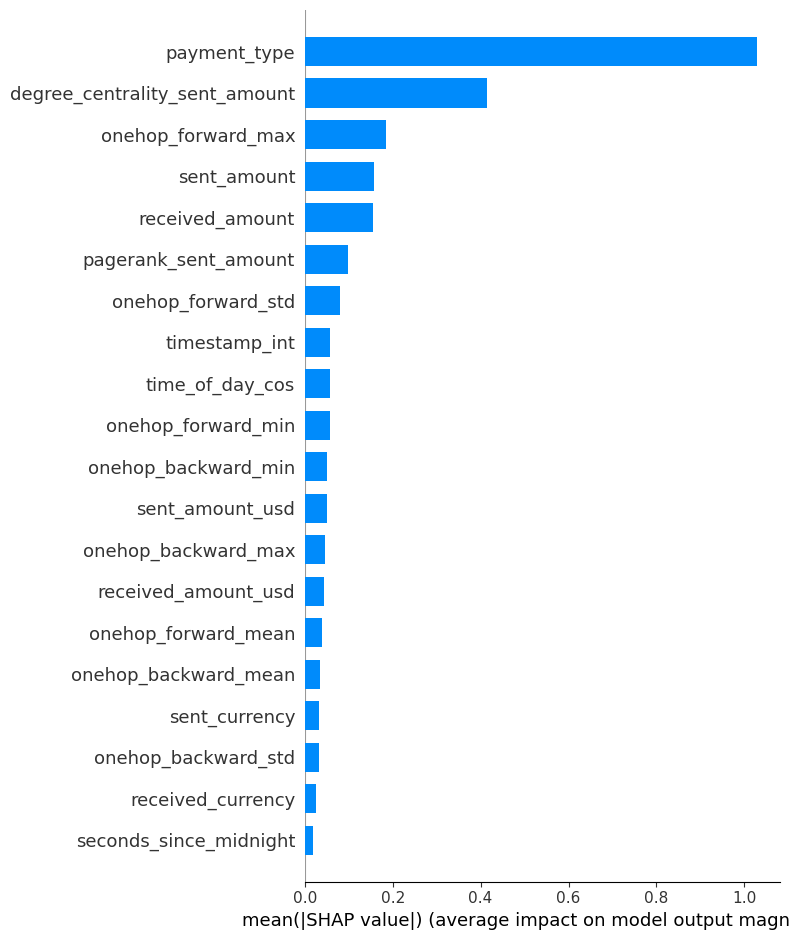

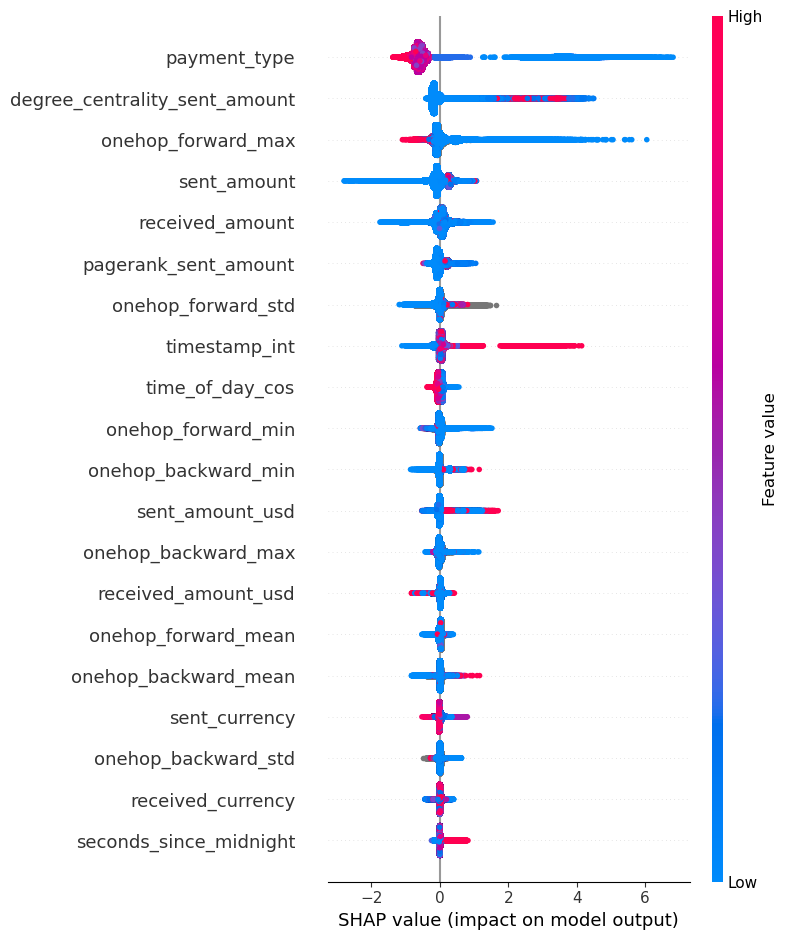

: 

In [ ]:

# SHAP Feature Importance
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train, check_additivity=False)

# Summary Plot (Global Feature Importance)
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Optional: Summary dot plot (per-sample contribution)
shap.summary_plot(shap_values, X_train)

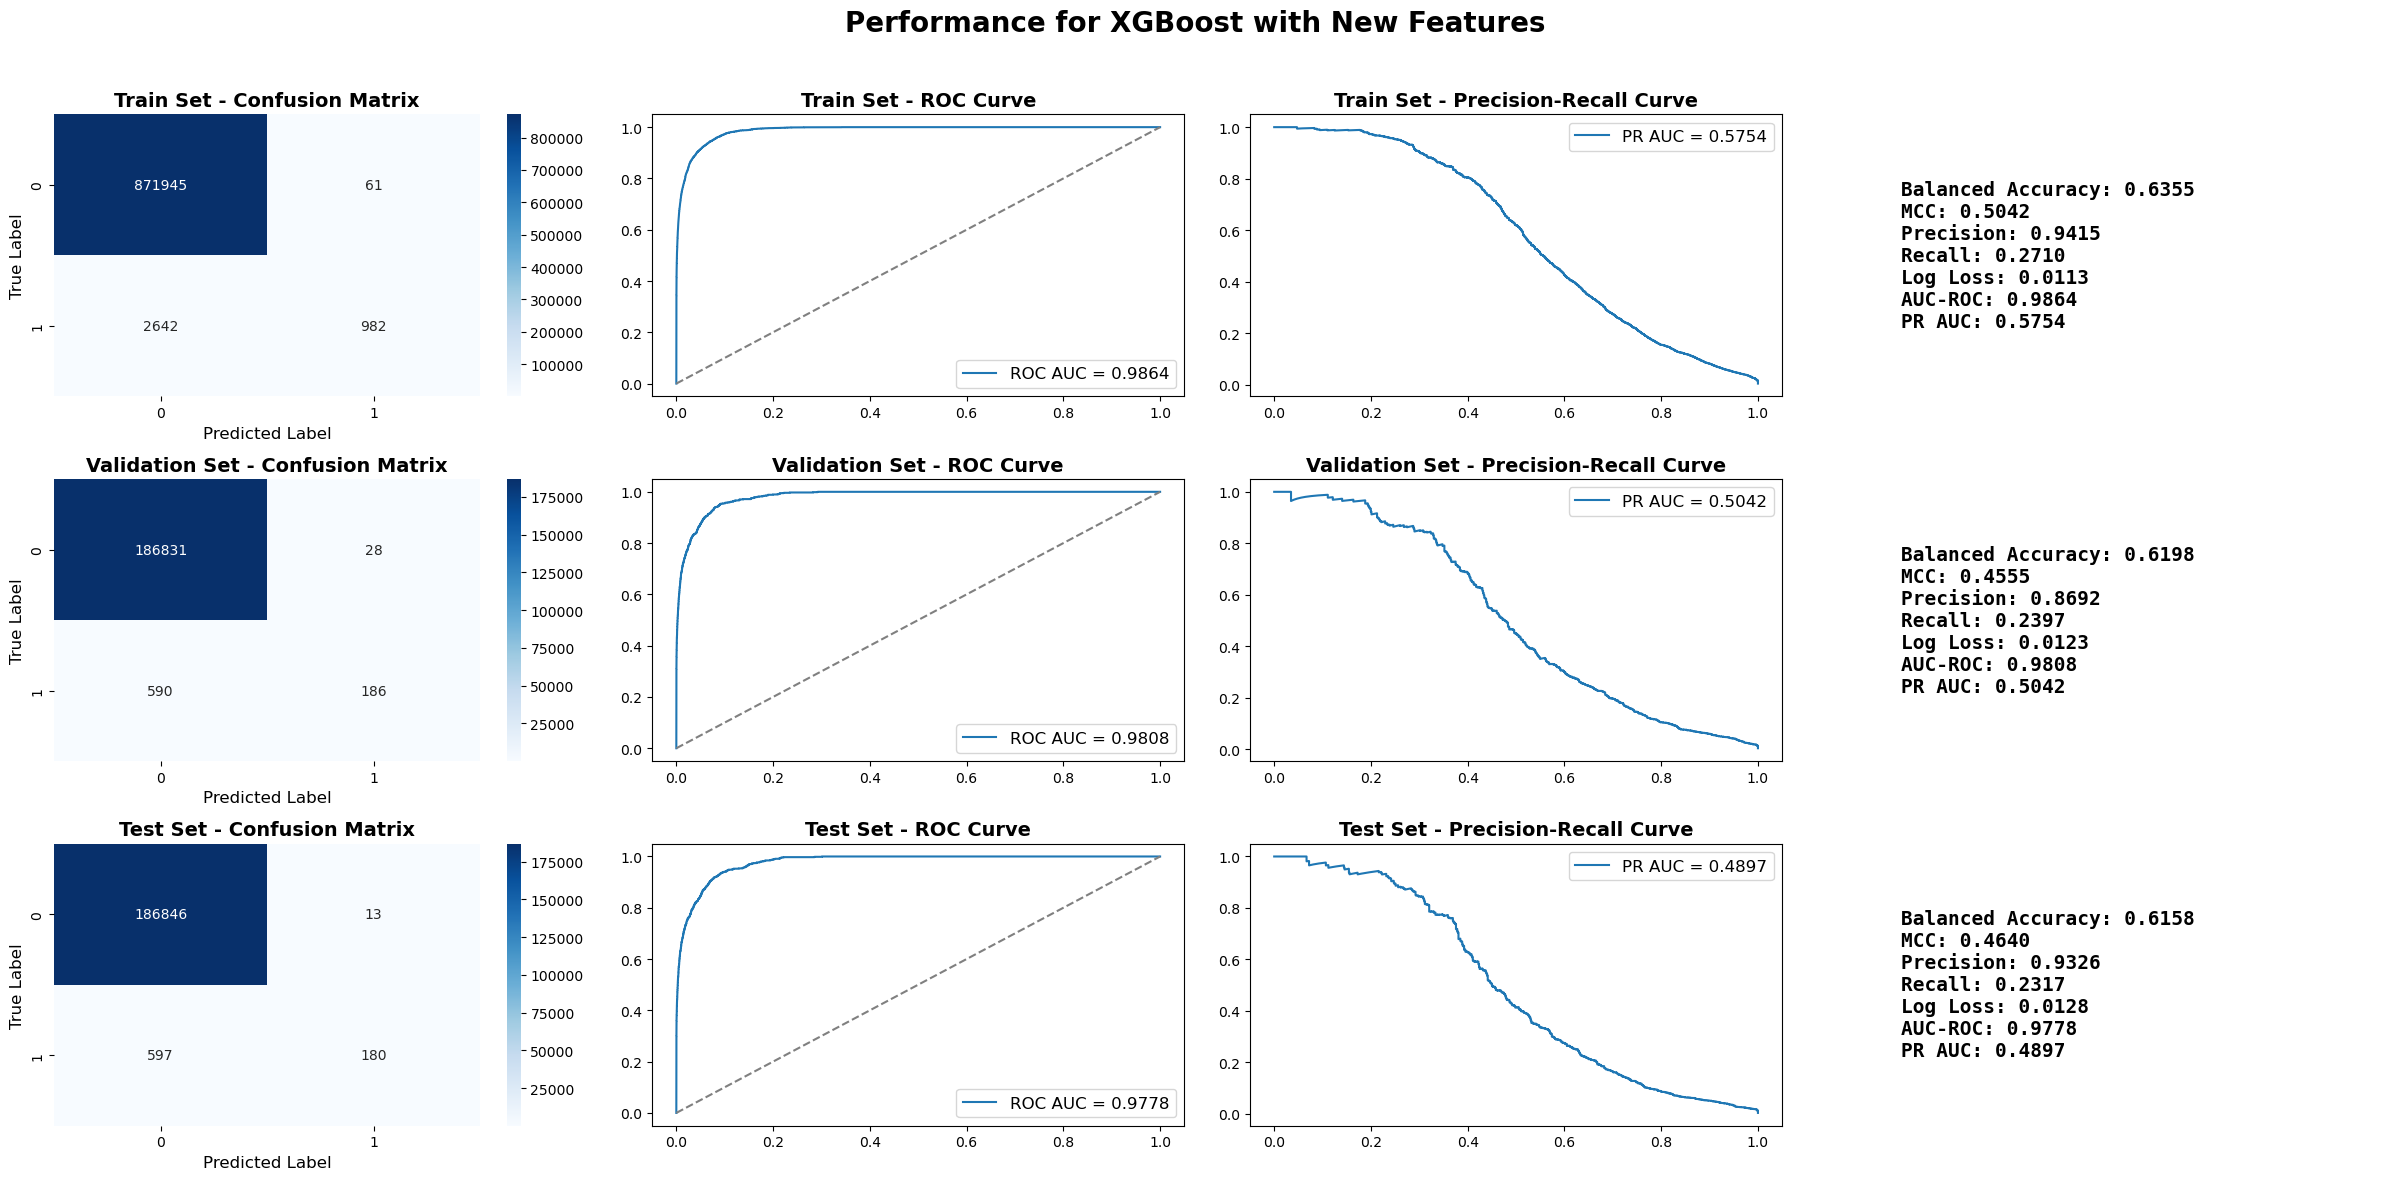

In [10]:
# Train predictions
train_proba = model.predict_proba(X_train)[:, 1]  # Get probability of class 1
train_pred = (train_proba > 0.5).astype(int)

# Validation predictions
val_proba = model.predict_proba(X_val)[:, 1]
val_pred = (val_proba > 0.5).astype(int)

# Test predictions
test_proba = model.predict_proba(X_test)[:, 1]
test_pred = (test_proba > 0.5).astype(int)


# Evaluate Model Performance
slide_title = "Performance for XGBoost with New Features"
metrics_summary = xgb_pipeline.result_metrics(
    slide_title,
    y_train, train_pred, train_proba,
    y_val, val_pred, val_proba,
    y_test, test_pred, test_proba,
    class_labels=["Licit", "Illicit"]
)
